In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [4]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)
rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr)

0.215040576615822
CPU times: user 9.02 ms, sys: 45 µs, total: 9.07 ms
Wall time: 10.1 ms


### Load the data:

In [5]:
path_data = "Link_Prediction_Data/WN18/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [6]:
print(entity_list[:3], "\n", len(entity_list))

['00001740', '00001930', '00002137'] 
 40943


In [7]:
print(relation_list[:3], "\n", len(relation_list))

['_also_see', '_derivationally_related_form', '_has_part'] 
 18


In [8]:
len(train_triples)

141442

In [9]:
len(valid_triples)

5000

In [10]:
len(test_triples)

5000

In [11]:
len(train_valid_triples)

146442

In [12]:
test_filter = create_filter(test_triples, all_triples)  
valid_filter = create_filter(valid_triples, all_triples)  

### Create Sparse COO Train Tensor:

In [13]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(40943, 18, 40943)

## WRCP-ALS3:

In [20]:
max_iter = 2
rank = 25
l2 = 4e0
seed = 1

In [21]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 2min 25s, sys: 424 ms, total: 2min 26s
Wall time: 2min 25s


In [22]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.37019343151519174


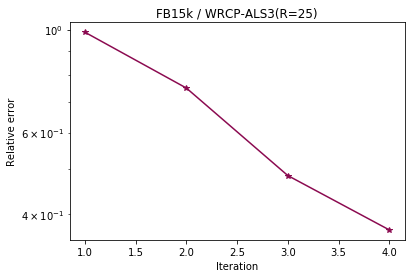

In [23]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"WN18 / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [24]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

CPU times: user 1min 4s, sys: 59.9 ms, total: 1min 4s
Wall time: 1min 4s


(0.006, 0.0076, 0.0186, 0.009544136896692298)

In [25]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 1min 2s, sys: 16 ms, total: 1min 2s
Wall time: 1min 2s


(0.0066, 0.01, 0.0184, 0.010646935754665765)

In [26]:
max_iter = [1, 2, 3, 4, 5]
rank = 25
l2 = [1e-2, 1e-1, 1e0, 2e0, 3e0, 4e0, 10e0]
seed = [1, 2, 3, 4, 5, 13, 15, 20]
for iterat in max_iter:
    for l in l2:
        for s in seed:
            a, b, c, err_arr, it = wrcp.wrcp_als3(
                coords, values, data_shape,
                rank=rank,
                l2=l,
                max_iter=iterat,
                seed=s,
                show_iter=False,
                it_over=False,
            ) 
            
            rerr = sqrt_err_relative(
                coords, values, data_shape, a, b, c,
            )
            
            hr1_test, hr3_test, hr10_test, mrr_test = hr(
                test_filter, test_triples, a, b, c, [1, 3, 10],
            )
            print(f"Iter {iterat}; l2 {l}; seed {s}; rerr {rerr}; hr10 {hr10_test}")

Iter 1; l2 0.01; seed 1; rerr 0.044586876318844275; hr10 0.0002
Iter 1; l2 0.01; seed 2; rerr 0.046398351463148614; hr10 0.0012
Iter 1; l2 0.01; seed 3; rerr 0.0417928811940498; hr10 0.0004
Iter 1; l2 0.01; seed 4; rerr 0.04966587630686783; hr10 0.0006
Iter 1; l2 0.01; seed 5; rerr 0.04370471002965868; hr10 0.0008
Iter 1; l2 0.01; seed 13; rerr 0.047369789729526324; hr10 0.0012
Iter 1; l2 0.01; seed 15; rerr 0.03944302433600558; hr10 0.001
Iter 1; l2 0.01; seed 20; rerr 0.03838642111149637; hr10 0.0008
Iter 1; l2 0.1; seed 1; rerr 0.05622159860753726; hr10 0.0002
Iter 1; l2 0.1; seed 2; rerr 0.05850623550188731; hr10 0.0008
Iter 1; l2 0.1; seed 3; rerr 0.053324349175273476; hr10 0.0002
Iter 1; l2 0.1; seed 4; rerr 0.06123065079570946; hr10 0.0002
Iter 1; l2 0.1; seed 5; rerr 0.057648419133066515; hr10 0.0002
Iter 1; l2 0.1; seed 13; rerr 0.06076234539290392; hr10 0.0012
Iter 1; l2 0.1; seed 15; rerr 0.051483034520534356; hr10 0.0002
Iter 1; l2 0.1; seed 20; rerr 0.051488345885313785; h

KeyboardInterrupt: 

## Find best parameters:

In [27]:
ranks = (25, 50, 100, 200, 300, 400, 600)
l2 = 3e0
n_iter = 2
seed = 2

In [28]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 14)),
    index=[i for i in range(1, len(ranks) + 1)],
    columns=("iter", "rank", "l2", "time_train",
             "time_hr", "error", "hr1_valid", "hr1_test",
             "hr3_valid", "hr3_test", "hr10_valid", "hr10_test", 
             "mrr_valid", "mrr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
    
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr1_valid, hr3_valid, hr10_valid, mrr_valid = hr(
        valid_filter, valid_triples, a, b, c, [1, 3, 10]
    )
    
    # Find Hit Rate on a test set
    hr1_test, hr3_test, hr10_test, mrr_test = hr(
        test_filter, test_triples, a, b, c, [1, 3, 10]
    )
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    
    table_results.loc[idx]["hr1_valid"] = hr1_valid
    table_results.loc[idx]["hr1_test"] = hr1_test
    
    table_results.loc[idx]["hr3_valid"] = hr3_valid
    table_results.loc[idx]["hr3_test"] = hr3_test
    
    table_results.loc[idx]["hr10_valid"] = hr10_valid
    table_results.loc[idx]["hr10_test"] = hr10_test
    
    table_results.loc[idx]["mrr_valid"] = mrr_valid
    table_results.loc[idx]["mrr_test"] = mrr_test 

 [████████████████████████████████████████████████████████████] 7/7 [04:33:41<02:27:41, 2345.89s/it]

In [30]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,2.0,25.0,3.0,78.475813,113.038850,0.494249,0.0112,0.0120,0.0178,0.0204,0.0308,0.0354,0.017554,0.019617
2,2.0,50.0,3.0,96.907700,135.724623,0.462726,0.0150,0.0124,0.0222,0.0174,0.0318,0.0300,0.021343,0.018476
3,2.0,100.0,3.0,203.526416,183.145085,0.449411,0.0070,0.0050,0.0154,0.0134,0.0242,0.0228,0.013403,0.011928
4,2.0,200.0,3.0,685.206816,326.373781,0.455659,0.0156,0.0144,0.0230,0.0230,0.0370,0.0380,0.022815,0.022534
5,2.0,300.0,3.0,1605.296109,445.614811,0.458242,0.0120,0.0120,0.0224,0.0246,0.0344,0.0398,0.020688,0.022955
6,2.0,400.0,3.0,3134.698787,551.552045,0.470979,0.0184,0.0198,0.0276,0.0298,0.0392,0.0434,0.026413,0.028456
7,2.0,600.0,3.0,8051.828079,808.912823,0.487731,0.0222,0.0242,0.0340,0.0346,0.0486,0.0528,0.031608,0.034004


In [31]:
table_results.to_csv("Link_Prediction_Factors/WN18/results.csv")

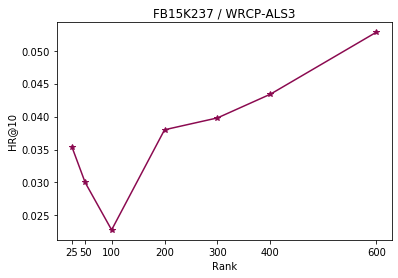

In [32]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"WN18 / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr10_test'], '-*', c="#8b0a50")